# Course 4: Mediapipe

`Mediapipe` is a framework for building multimodal (e.g. video, audio, any time series data), cross-platform (i.e. Android, iOS, web, edge devices) applied ML pipelines. It is used for research and production applications.

In this notebook, we will use `mediapipe` library to recognise the gesture, and train a model to recognise rock, paper and scissors gestures.

## Setup

First, we need to install the `mediapipe` library.

```bash
pip install mediapipe
```

Note that `mediapipe` requires `opencv-python` to be installed.

It is worthwhile to announce that in `OpenCV`, the default color space is `BGR`. So firstly, we need to convert the image to `RGB` color space.

```python
import cv2
dest = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
```

## Basic Concepts

`Mediapipe` provides a variety of models for different tasks. For example, `Hands` model is used to detect hands and hand landmarks. `Pose` model is used to detect human poses. `Face` model is used to detect faces and facial landmarks. Take `Hands` as an example, we can recognize nodes (about 21) of a hand.

In [15]:
import cv2
import torch

import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

image = cv2.imread('./mediapipe/victory.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = hands.process(image)

h, w, c = image.shape

if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

cv2.imshow('Hand Tracking', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

hands.close()

I0000 00:00:1721134559.276552  404695 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Pro
W0000 00:00:1721134559.283286  445423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721134559.289613  445423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


KeyboardInterrupt: 

Chore: integrate the camera and recognize hands promptly.

In [51]:
camera = cv2.VideoCapture(0)
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

while True:
    ret, image = camera.read()
    if not ret:
        break

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    h, w, c = image.shape

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    cv2.imshow('Hand Tracking', image)
    if cv2.waitKey(1) and 0xFF == ord('q'):
        break

camera.release()
hands.close()
cv2.destroyAllWindows()

I0000 00:00:1721129416.564226  280736 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Pro
W0000 00:00:1721129416.569112  339687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721129416.575007  339687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


KeyboardInterrupt: 

## Gesture Recognition based on rules

- `results.multi_hand_landmarks` is a list containing two left and right hand landmark values.  
Each of these elements can be accessed point by point using `landmark.landmark`
- `mcp` metacarpophalangeal joint
- `ip` interphalangeal joint
- `pip` proximal interphalangeal joint
- `dip` distal interphalangeal joint
- `cmc` carpometacarpal joint

> Because its implementation is too rude, I just adapted from the source and did not modify it.

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

image = cv2.imread('./mediapipe/victory.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = hands.process(image)
h, w, c = image.shape

lst_lms = []

# Add all gesture coordinate points to a list [(x1, y1), (x2, y2),....] Total 21
if results.multi_hand_landmarks:
    for single_hand_marks in results.multi_hand_landmarks:
        for id, lm in enumerate(single_hand_marks.landmark):
            # The original `lm.x` and `lm.y` are decimals, multiplied by `w` and `h` to make the true coordinates
            x, y = int(w * lm.x), int(h * lm.y)
            cv2.circle(image, (x, y), 2, (255, 1, 0), -1)
            lst_lms.append([x, y])

lst_lms = np.array(lst_lms)
hull_index = [0, 1, 2, 3, 6, 10, 14, 18, 17]  # Taking out nine points of the incoming target.
hull = cv2.convexHull(lst_lms[hull_index, :])  # Connecting the nine points into a closed loop.

cv2.polylines(image, [hull], True, (222, 222, 0), 2)  # Draw out this closed loop

up_finger = []  # Here's the list outside the closed loop

# Rotate these five fingertip points to see which ones are outside the closed loop of the above
for i in [4, 8, 12, 16, 20]:
    point = (int(lst_lms[i][0]), int(lst_lms[i][1]))
    # Calculates the distance from the point to the outline, less than 0 means outside the outline.
    dist = cv2.pointPolygonTest(hull, point, True)
    print(dist)
    if dist < 0:
        up_finger.append(i)
print(up_finger)

if len(up_finger) == 1 and up_finger[
    0] == 8:  # If there is only one point outside the closed loop and this hand is point 8
    guesture = 'one'
else:
    guesture = 'None'

if guesture:
    cv2.putText(image, guesture, (30, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (222, 21, 122), 1)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cv2.imshow('MediaPipe Hand Tracking', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
hands.close()

## Gesture Recognition based on Machine Learning

Via `PyTorch` and some datasets, we can easily recognise the gestures of rock, paper and scissors.

We set the classifier as 4 results, including rock, paper, scissors and none.

Unfortunately, official `mediapipe` supports TensorFlow (made by Google) but not PyTorch, so we can't use the bridge library (`mediapipe_model_maker`), and we need to implement the model by ourselves.

### Input Layer

We first perform the recognition via `mediapipe` and then use the coordinates of the hand landmarks as the input of the model, returning them as $(\mathrm{id}, x, y)$. Then we can use these coordinates to train the model.

In [91]:
import cv2
import mediapipe as mp
from cv2.typing import MatLike
import numpy as np
from PIL import Image

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils


class ToNumpy:
    def __call__(self, image: Image):
        return np.array(image)


class CropToHand:
    def __call__(self, image: MatLike):
        global y_min, y_max, x_min, x_max, hand_image_resized
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Get the bounding box coordinates of the hand
                image_height, image_width, _ = image.shape
                x_min = image_width
                y_min = image_height
                x_max = y_max = 0
                for landmark in hand_landmarks.landmark:
                    x = int(landmark.x * image_width)
                    y = int(landmark.y * image_height)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)

            # Crop the hand region from the frame
            hand_image = image[y_min:y_max, x_min:x_max]

            # Resize the cropped hand image to 256x256
            hand_image_resized = cv2.resize(hand_image, (256, 256))
            return hand_image_resized
        else:
            return image.reshape((256, 256))


class ExtractKeypoints:
    def __init__(self, hands: mp_hands.Hands):
        self.hands = hands

    def __call__(self, image: MatLike) -> np.ndarray:
        image = cv2.resize(image, (256, 256))
        results = hands.process(image)
        h, w, c = image.shape
        lst_lms = []
        x0, y0 = 0, 0
        if results.multi_hand_landmarks:
            for single_hand_marks in results.multi_hand_landmarks:
                for id, lm in enumerate(single_hand_marks.landmark):
                    if id == 0:
                        x0, y0 = int(w * lm.x), int(h * lm.y)
                    else:
                        x, y = int(w * lm.x) - x0, int(h * lm.y) - y0
                        lst_lms.append([id, x, y])

        return np.array(lst_lms, dtype=np.float32)


class HandleGestureDataset:
    def __init__(self):
        pass

    def __call__(self, matrix: np.ndarray):
        # assert matrix.shape == (20, 3)
        if matrix.shape == (0, 0) or matrix.shape == (0,):
            matrix = np.random.random((5, 4, 2))
            return matrix
        # Find the missed points
        if matrix.shape[0] < 20:
            print(matrix, matrix.shape)
            for i in range(1, 21):
                if i not in matrix[:, 0]:
                    matrix = np.insert(matrix, i, [i, 0, 0], axis=0)
        matrix = matrix[:, 1:]
        matrix = matrix.reshape(5, 4, 2)
        return matrix


image = cv2.imread('./mediapipe/victory.jpg')

points = ExtractKeypoints(hands)(image)
handler = HandleGestureDataset()
handler(points)

I0000 00:00:1721143386.150323  501527 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Pro
W0000 00:00:1721143386.159228  596082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721143386.174467  596087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


array([[[0.12751513, 0.77302608],
        [0.99676086, 0.1109649 ],
        [0.54248654, 0.84478489],
        [0.0403181 , 0.63635634]],

       [[0.5680334 , 0.58604737],
        [0.9649382 , 0.67915948],
        [0.62460439, 0.30138774],
        [0.72046154, 0.39264402]],

       [[0.38195711, 0.42170839],
        [0.282968  , 0.53531874],
        [0.07656078, 0.69323677],
        [0.15824243, 0.83834411]],

       [[0.45822561, 0.5945944 ],
        [0.09482474, 0.2997905 ],
        [0.69346236, 0.97356866],
        [0.66157453, 0.29434463]],

       [[0.38733862, 0.71666604],
        [0.54533886, 0.50941536],
        [0.86866136, 0.06246212],
        [0.31820268, 0.42935677]]])

### Datasets

We can use the `rock_paper_scissors` dataset (downloaded to ./mediapipe/rps folder) to train the model. Via `ImageFolder`, these images can be loaded easily.

In [92]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, random_split

device = torch.device('mps')

data_transform = transforms.Compose([
    transforms.RandomRotation((-90, 90)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    ToNumpy(),
    ExtractKeypoints(hands),
    HandleGestureDataset(),
    transforms.ToTensor(),
])

dataset = ImageFolder('./mediapipe/rps', transform=data_transform)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Neural Network Design

Inspired by convolutional neural networks, we firstly use convolutional layers to extract features, and then use fully connected layers to classify the gestures. Finally, we use the softmax function to output the probabilities of each gesture.

In [93]:
class GestureClassifier(nn.Module):
    def __init__(self):
        super(GestureClassifier, self).__init__()
        # Define convolution and pooling layers
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2, padding=1, stride=1)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=1)
        # Fully connected layers
        self.fc1 = nn.Linear(40, 64)  # Adjusted to match the output shape after conv and pooling
        self.fc2 = nn.Linear(64, 4)
        self.output = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        batch_size = x.size(0)
        slices = []

        # Loop over the 5 slices in the input
        for i in range(5):
            slice = x[:, :, i, :].unsqueeze(1)  # Extract the i-th slice and add channel dimension
            conv_out = self.conv(slice)
            pool_out = self.pooling(conv_out)
            slices.append(pool_out)

        # Stack the slices and flatten
        x = torch.cat(slices, dim=1)  # Concatenate slices along the channel dimension
        x = x.view(batch_size, -1)  # Flatten to (batch_size, 5 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.output(x)
        return x


model = GestureClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

### Training

We can train the model via the following code.

In [94]:
train_model = False
if train_model:
    from tqdm import tqdm

    for epoch in range(epochs):
        for (data, target) in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            data, target = data.float().to(device), target.float().to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item() / batch_size}')

        with torch.no_grad():
            correct = 0
            total = 0
            for (data, target) in tqdm(val_loader):
                data, target = data.float().to(device), target.float().to(device)
                output = model(data)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            accuracy = correct / total
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}')

    torch.save(model.state_dict(), './mediapipe/gesture_classifier.pth')
else:
    model.load_state_dict(torch.load('./mediapipe/gesture_classifier.pth'))

### Evaluate the Model

We can call the camera and evaluate the model.

In [192]:
def have_hand(image: MatLike):
    results = hands.process(image)
    if results.multi_hand_landmarks:
        return True
    return False


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
camera = cv2.VideoCapture(0)

model.eval()

I0000 00:00:1721145824.746596  501527 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Pro
W0000 00:00:1721145824.751908  637930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721145824.756987  637928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


GestureClassifier(
  (conv): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (output): Softmax(dim=1)
  (dropout): Dropout(p=0.7, inplace=False)
)

### Final Game: Play Rock, Paper, Scissors with the Computer!

Via `random`, we can play the game with the computer.

1. Computer set the countdown;
2. Random the computer's action (rock, paper, scissors);
3. Recognize the player's action;
4. Compare the results.

Let's begin.

#### 1. Computer set the countdown

In [53]:
import time

for i in range(3, 0, -1):
    print(i)
    time.sleep(1)

print('Go!')

time.sleep(0.1)

3
2
1
Go!


#### 2. Random the computer's action

We can use `random` to random the computer's action.

In [63]:
import random

actions = ['paper', 'rock', 'scissors']

computer_action = random.choice(actions)

#### 3. Recognize the player's action

Get 30 frames to recognize the player's action, it can reduce the risk of misjudgment.

In [197]:
for i in range(3, 0, -1):
    print(i)
    time.sleep(1)

print('Go!')

import random

actions = ['paper', 'rock', 'scissors']

computer_action = random.choice(actions)

player_action = None
record = [0, 0, 0, 0]

for _ in range(30):
    ret, image = camera.read()
    if not ret:
        break
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformer = transforms.Compose([
        ExtractKeypoints(hands),
        HandleGestureDataset(),
        transforms.ToTensor(),
    ])
    if have_hand(image):
        src = transformer(image).float().to(device)
        with torch.no_grad():
            output = model(src.unsqueeze(0))
            _, predicted = torch.max(output, 1)
            record[predicted.item()] += 1

if max(record) == record[0]:
    player_action = 'none'
elif max(record) == record[1]:
    player_action = 'paper'
elif max(record) == record[2]:
    player_action = 'rock'
else:
    player_action = 'scissors'

print(f"Player's action: {player_action}, Computer's action: {computer_action}")

3
2
1
Go!
Player's action: paper, Computer's action: rock


#### 4. Compare the results

In [198]:
root_dir = '/Users/ethangoh/Library/Containers/io.playcover.PlayCover/Applications/'
icon_dir = './mediapipe/games/'
msg = ''

if player_action == 'none':
    msg = 'You did not make any action.'
    root_dir += 'games.Pigeon.Phigros.app'
    icon_dir += 'phigros.png'
elif player_action == computer_action:
    msg = 'Draw!'
    root_dir += 'com.miHoYo.hkrpg.app'
    icon_dir += 'hsr.png'
elif (player_action == 'rock' and computer_action == 'scissors') or (
        player_action == 'scissors' and computer_action == 'paper') or (
        player_action == 'paper' and computer_action == 'rock'):
    msg = 'You win!'
    root_dir += 'com.miHoYo.Nap.app'
    icon_dir += 'zzz.png'
else:
    msg = 'You lose!'
    root_dir += 'com.miHoYo.Yuanshen.app'
    icon_dir += 'genshin.png'

print(msg)

import os
import matplotlib.pyplot as plt
import pygame

# Initialize the mixer module
pygame.mixer.init()

# Load the audio file
pygame.mixer.music.load('./mediapipe/launch.mp3')

try:
    # Launch!
    # Play the audio file
    os.system(f'open -a {root_dir}')
    time.sleep(1.5)
    pygame.mixer.music.play()
except:
    if root_dir.endswith('Yuanshen.app'):
        os.system(f'open https://ys.mihoyo.com/cloud/#/')
    elif root_dir.endswith('hkrpg.app'):
        os.system(f'open https://sr.mihoyo.com/cloud/#/')

You win!


#### Chore: Display the combat with mosaic face of user

Via `mp.solutions.face_detection`, we can easily apply the mosaic effect to the face of the user to protect privacy.

I0000 00:00:1721145896.029305  501527 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2 Pro
W0000 00:00:1721145896.042994  640011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


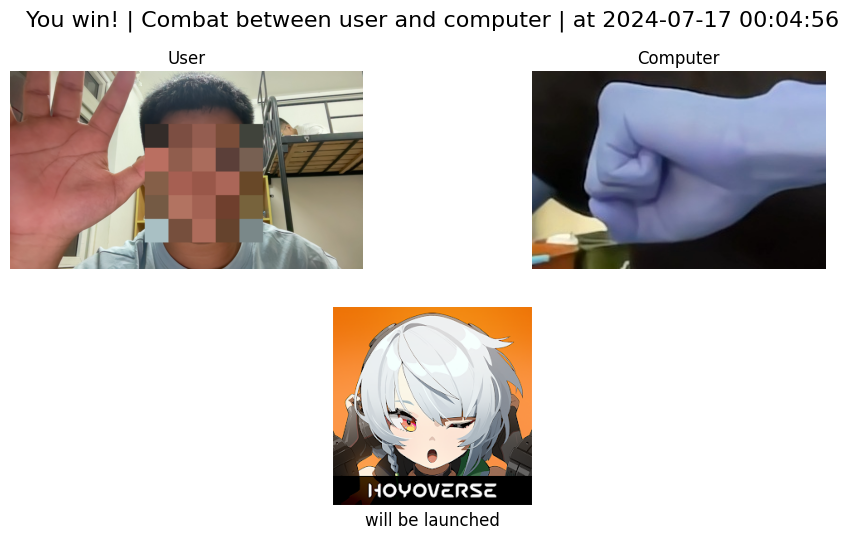

In [199]:
user = image
dir_of_computer = f'./mediapipe/rps/{computer_action}/'
computer = cv2.imread(dir_of_computer + random.choice(os.listdir(dir_of_computer)))

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Function to apply mosaic effect to a region
def apply_mosaic(image, x, y, w, h, size=5):
    sub_face = image[y:y + h, x:x + w]
    sub_face = cv2.resize(sub_face, (size, size), interpolation=cv2.INTER_LINEAR)
    sub_face = cv2.resize(sub_face, (w, h), interpolation=cv2.INTER_NEAREST)
    image[y:y + h, x:x + w] = sub_face
    return image


def auto_mosaic(image: MatLike):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image)

    if results.detections:
        for detection in results.detections:
            # Get the bounding box coordinates
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

            # Apply mosaic to the detected face
            image = apply_mosaic(image, x, y, w, h, size=5)
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

from matplotlib.gridspec import GridSpec
from datetime import datetime

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(3, 2, height_ratios=[1, 1, 0.2])

# Add a title to the figure
date_and_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
fig.suptitle(f"{msg} | Combat between user and computer | at {date_and_time}", fontsize=16)

# First subplot: User image with mosaic
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(auto_mosaic(user))
ax1.set_title('User')
ax1.axis('off')

# Second subplot: Computer image
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(computer)
ax2.set_title('Computer')
ax2.axis('off')

# Third subplot: Icon with comment spanning both columns
ax3 = fig.add_subplot(gs[1, :])
icon = cv2.cvtColor(cv2.imread(icon_dir), cv2.COLOR_BGR2RGB)
ax3.imshow(icon)
ax3.axis('off')
ax3.text(0.5, -0.1, 'will be launched', transform=ax3.transAxes, ha='center', fontsize=12, color='black')

# Adjust layout
plt.tight_layout()
plt.show()

In [200]:
camera.release()